# Data Science Capstone Project - The Battle of Neighborhoods: Chicago, Illinois

### The aim of the project is to suggest the neighborhood in the city of Chicago, based on per capita income and lower crime rate. 
* Building a dataframe of neighborhoods in Chicago, Illinois by web scraping the community areas data from the Wikipedia page.
* Building another dataframe based on Crime Statistics of each neighborhood in the city of Chicago and social economic dataset containing demographic details.
* Creating a consolidated dataset consisting of community areas, crime statistics data, per capita income, and the respective neighborhood coordinates. 
* Obtain the venue data for the neighborhoods using the Foursquare API. 
* Creating a new conolidated dataset consisting of community areas, crime statistics data, per capita income, neighborhoods, the most common venues within the respective neighborhood along with the coordinates.
* Explore and cluster the neighborhoods.
* Suggesting the best cluster including the per capita income, lower crime rate, and the nearby venues. 

### 1. Import Libraries

In [25]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

!pip install geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

print("Libraries imported.")

Libraries imported.


### 2. Webscraping data from Wikipedia page into a DataFrame using BeautifulSoup package

In [26]:
# send the GET request
data = requests.get("https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago").text

In [27]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')

In [28]:
# create a list to store neighborhood data
neighborhoodList = []
communityList = []

In [29]:
# append the data into the list
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        neighborhoodList.append(cells[0].text.rstrip('\n'))
        communityList.append(cells[1].text.rstrip('\n'))

In [30]:
# create a new DataFrame from the list
neighborhood_df = pd.DataFrame({"Neighborhood": neighborhoodList,
                        "Community Area": communityList})

#Renaming the column 
neighborhood_df.rename(columns={'Community Area':'Community Area Name'}, inplace = True) 

neighborhood_df.head()

,Neighborhood,Community Area Name
0,Albany Park,Albany Park
1,Altgeld Gardens,Riverdale
2,Andersonville,Edgewater
3,Archer Heights,Archer Heights
4,Armour Square,Armour Square


In [31]:
# print the number of rows of the dataframe
neighborhood_df.shape

(246, 2)

### 3. Reading the Chicago Crime Dataset
The real world dataset has been found from Kaggle containing Chicago crimes. The dataset contains 600,000 rows approx. and it is not possible to process all the data. Therefore, for this project we will just be considering the recent crime report of 2020. 

In [32]:
!wget -q -O 'chicago_crime.csv' https://data.cityofchicago.org/api/views/qzdf-xmn8/rows.csv?accessType=DOWNLOAD
chicago_crime=pd.read_csv('chicago_crime.csv')
chicago_crime.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12070504,JD251166,06/02/2020 10:11:00 AM,001XX N OAKLEY BLVD,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,False,1223,12,27.0,28,08B,1161054.0,1901054.0,2020,06/10/2020 03:46:57 PM,41.884180,-87.684048,"(41.884180033, -87.684048419)"
1,12070768,JD255590,05/31/2020 04:00:00 PM,001XX W 95TH ST,0810,THEFT,OVER $500,SMALL RETAIL STORE,False,False,634,6,21.0,49,06,1177048.0,1841963.0,2020,06/10/2020 03:46:57 PM,41.721682,-87.627100,"(41.721681725, -87.627099997)"
2,12067497,JD252152,06/03/2020 09:55:00 AM,012XX N CLYBOURN AVE,0320,ROBBERY,STRONG ARM - NO WEAPON,BANK,False,False,1821,18,27.0,8,03,1172996.0,1908394.0,2020,06/10/2020 03:49:15 PM,41.904065,-87.639978,"(41.90406511, -87.63997849)"
3,12069889,JD253440,05/31/2020 04:00:00 AM,006XX S WELLS ST,1310,CRIMINAL DAMAGE,TO PROPERTY,OTHER (SPECIFY),False,False,123,1,25.0,32,14,1174818.0,1897412.0,2020,06/10/2020 03:46:57 PM,41.873889,-87.633615,"(41.873889276, -87.633614833)"
4,12067925,JD252507,06/03/2020 01:30:00 PM,009XX W FULLERTON AVE,1210,DECEPTIVE PRACTICE,THEFT OF LABOR / SERVICES,CTA STATION,False,False,1812,18,43.0,7,11,1169577.0,1916141.0,2020,06/10/2020 03:49:15 PM,41.925398,-87.652311,"(41.925398449, -87.652311296)"


### 4. Reading the Chicago Census Data

In [33]:
chicago_CensusData=pd.read_csv('https://ibm.box.com/shared/static/05c3415cbfbtfnr2fx4atenb2sd361ze.csv',header=None)
chicago_CensusData.head()

,0,1,2,3,4,5,6,7,8
0,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER_CAPITA_INCOME,HARDSHIP_INDEX
1,1,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39
2,2,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46
3,3,Uptown,3.8,24,8.9,11.8,22.2,35787,20
4,4,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17


### 5. Cleaning, formatting, and processing the Chicago Crime Dataset

In [34]:
CrimeData=chicago_crime.drop(0,axis=0)
# Rename columns
CrimeData.rename(columns={'Community Area':'Community Area Number'}, inplace = True) 
# Dropping null values
CrimeData.dropna(inplace=True) 
CrimeData.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area Number,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1,12070768,JD255590,05/31/2020 04:00:00 PM,001XX W 95TH ST,0810,THEFT,OVER $500,SMALL RETAIL STORE,False,False,634,6,21.0,49,06,1177048.0,1841963.0,2020,06/10/2020 03:46:57 PM,41.721682,-87.627100,"(41.721681725, -87.627099997)"
2,12067497,JD252152,06/03/2020 09:55:00 AM,012XX N CLYBOURN AVE,0320,ROBBERY,STRONG ARM - NO WEAPON,BANK,False,False,1821,18,27.0,8,03,1172996.0,1908394.0,2020,06/10/2020 03:49:15 PM,41.904065,-87.639978,"(41.90406511, -87.63997849)"
3,12069889,JD253440,05/31/2020 04:00:00 AM,006XX S WELLS ST,1310,CRIMINAL DAMAGE,TO PROPERTY,OTHER (SPECIFY),False,False,123,1,25.0,32,14,1174818.0,1897412.0,2020,06/10/2020 03:46:57 PM,41.873889,-87.633615,"(41.873889276, -87.633614833)"
4,12067925,JD252507,06/03/2020 01:30:00 PM,009XX W FULLERTON AVE,1210,DECEPTIVE PRACTICE,THEFT OF LABOR / SERVICES,CTA STATION,False,False,1812,18,43.0,7,11,1169577.0,1916141.0,2020,06/10/2020 03:49:15 PM,41.925398,-87.652311,"(41.925398449, -87.652311296)"
5,25162,JD249292,06/03/2020 12:08:00 AM,003XX W 64TH ST,0110,HOMICIDE,FIRST DEGREE MURDER,HOSPITAL,False,False,722,7,20.0,68,01A,1175044.0,1862506.0,2020,06/10/2020 03:49:15 PM,41.778099,-87.633829,"(41.778099133, -87.633828531)"


### 6.  Cleaning, formatting, and processing the Chicago Census Dataset

In [35]:
CensusData=chicago_CensusData.drop(0,axis=0)
# Dropping unwanted columns
CensusData.drop([2,3,4,5,6,8], axis = 1, inplace = True) 
# Rename columns
CensusData.rename(columns={1:'Community Area Name',0:'Community Area Number',7:'Per_Capita_Income'}, inplace = True) 
# Dropping null values
CensusData.dropna(inplace=True) 
# Converting numeric columns from float64 to int64
CensusData['Per_Capita_Income']=CensusData['Per_Capita_Income'].astype('int64')
CensusData['Community Area Number']=CensusData['Community Area Number'].astype('int64')
CensusData.head()

,Community Area Number,Community Area Name,Per_Capita_Income
1,1,Rogers Park,23939
2,2,West Ridge,23040
3,3,Uptown,35787
4,4,Lincoln Square,37524
5,5,North Center,57123


### 7. Merging Chicago Crime Dataset and Census Dataset

In [36]:
# Grouping the Chicago Crime Data on District and Community Area Number and the counts of Primary Type of Crimes in each District and specific Community Area
chicago_district_crime = CrimeData.groupby(['District','Community Area Number'])[['Primary Type']].count()
# Merging the Chicago Census Data and the chicago_district_crime Data on Community Area Number
chicago_community_merged = pd.merge(CensusData,chicago_district_crime,on='Community Area Number')
# Grouping the data on Community Area Number and Community Area Name and total counts of Primary Type of Crimes in each Community Area
chicago_community = chicago_community_merged.groupby(['Community Area Number','Community Area Name'])[['Primary Type']].sum()
# Merging the Chicago Census Data and the chicago_community Data on Community Area Number
chicago_community_final = pd.merge(CensusData,chicago_community,on='Community Area Number')
# Renaming the Primary Type column to Total Cases
chicago_community_final.rename(columns={'Primary Type':'Total_Cases'}, inplace = True)
# Sorting the values of Total Cases
chicago_community_final.sort_values('Total_Cases', ascending = True)
# Displaying the first 5 rows of the final community area dataset
chicago_community_final.head()

,Community Area Number,Community Area Name,Per_Capita_Income,Total_Cases
0,1,Rogers Park,23939,1279
1,2,West Ridge,23040,1125
2,3,Uptown,35787,1092
3,4,Lincoln Square,37524,682
4,5,North Center,57123,451


In [37]:
chicago_community_final.describe()

,Community Area Number,Per_Capita_Income,Total_Cases
count,77.000000,77.000000,77.000000
mean,39.000000,25563.168831,1082.831169
std,22.371857,15293.098259,928.633042
min,1.000000,8201.000000,79.000000
25%,20.000000,15754.000000,417.000000
50%,39.000000,21323.000000,745.000000
75%,58.000000,28887.000000,1533.000000
max,77.000000,88669.000000,5084.000000


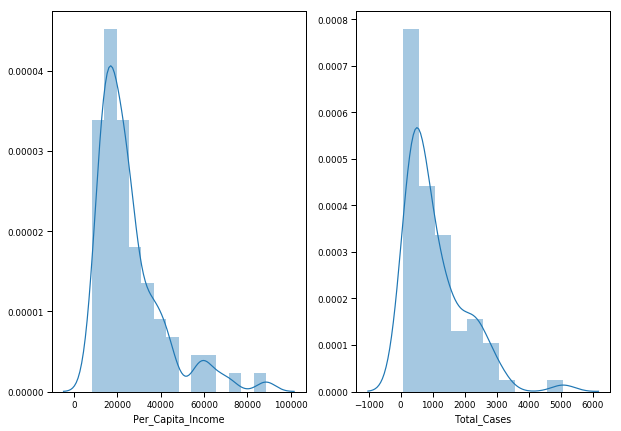

In [38]:
fig,ax=plt.subplots(1,2,figsize = (10,7))
sns.distplot(chicago_community_final['Per_Capita_Income'], ax=ax[0])
sns.distplot(chicago_community_final['Total_Cases'], ax=ax[1])
fig.show()

### 8. Distribution of Per_Capita_Income by Community Area

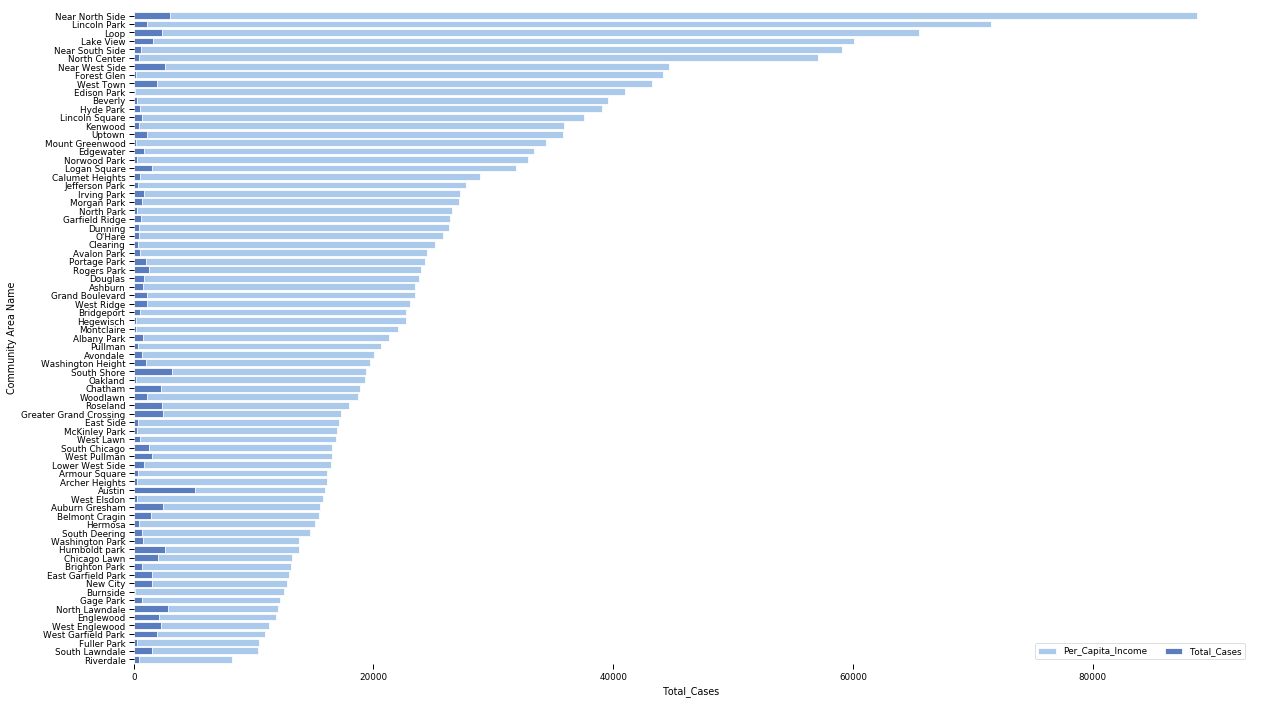

In [39]:
sns.set_context('paper')
chicago_plot=chicago_community_final.copy()
chicago = chicago_plot.sort_values('Per_Capita_Income', ascending = False)
f, ax = plt.subplots(figsize = (20,12))
sns.set_color_codes('pastel')
sns.barplot(x = 'Per_Capita_Income' , y = 'Community Area Name', data = chicago,
            label = 'Per_Capita_Income', color = 'b', edgecolor = 'w')

sns.set_color_codes('muted')
sns.barplot(x = 'Total_Cases', y = 'Community Area Name', data = chicago,
            label = 'Total_Cases', color = 'b', edgecolor = 'w')
ax.legend(ncol = 2, loc = 'lower right')
sns.despine(left = True, bottom = True)
plt.show()

**Selecting top 50 Community Areas with higher per capita income and total crime cases less than 800**

In [40]:
#top 50 areas with highest per capita income
top_20=chicago_community_final.nlargest(50,'Per_Capita_Income') 
chicago_area=top_20[top_20['Total_Cases']<800]
chicago_final=chicago_area.sort_values('Per_Capita_Income', ascending = False)
chicago_final.drop('Community Area Number',axis=1,inplace=True)
chicago_final.reset_index(inplace=True,drop=True)
chicago_final

,Community Area Name,Per_Capita_Income,Total_Cases
0,Near South Side,59077,614
1,North Center,57123,451
2,Forest Glen,44164,189
3,Edison Park,40959,79
4,Beverly,39523,296
5,Hyde Park,39056,508
6,Lincoln Square,37524,682
7,Kenwood,35911,417
8,Mount Greenwood,34381,170
9,Norwood Park,32875,291


**Restricting the rows in the data frame to only those with Community Areas in the chicago_chicago_community_final**

In [41]:
df=neighborhood_df[neighborhood_df['Community Area Name'].isin(chicago_community_final['Community Area Name'])]
df

,Neighborhood,Community Area Name
0,Albany Park,Albany Park
1,Altgeld Gardens,Riverdale
2,Andersonville,Edgewater
3,Archer Heights,Archer Heights
4,Armour Square,Armour Square
5,Ashburn,Ashburn
6,Ashburn Estates,Ashburn
7,Auburn Gresham,Auburn Gresham
8,Avalon Park,Avalon Park
9,Avondale,Avondale


### 9. Getting the geographical coordinates of all the neighborhoods

In [42]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Chicago, Illinois'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [43]:
# call the function to get the coordinates, store in a new list using list comprehension
coords = [get_latlng(neighborhood) for neighborhood in df["Neighborhood"].tolist()]

Status code Unknown from https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/find: ERROR - HTTPSConnectionPool(host='geocode.arcgis.com', port=443): Read timed out. (read timeout=5.0)
Status code Unknown from https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/find: ERROR - HTTPSConnectionPool(host='geocode.arcgis.com', port=443): Read timed out. (read timeout=5.0)
Status code Unknown from https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/find: ERROR - HTTPSConnectionPool(host='geocode.arcgis.com', port=443): Read timed out. (read timeout=5.0)
Status code Unknown from https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/find: ERROR - HTTPSConnectionPool(host='geocode.arcgis.com', port=443): Read timed out. (read timeout=5.0)
Status code Unknown from https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/find: ERROR - HTTPSConnectionPool(host='geocode.arcgis.com', port=443): Read timed out. (read timeout=5.0)


In [46]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_coords

,Latitude,Longitude
0,41.968290,-87.723380
1,41.654410,-87.602250
2,41.980460,-87.668340
3,41.811540,-87.725560
4,41.834580,-87.631890
5,41.747850,-87.709950
6,41.941674,-88.198809
7,41.743190,-87.655040
8,41.745070,-87.588160
9,41.939250,-87.711250


In [58]:
# merge the coordinates into the original dataframe
df.loc[ :,['Latitude']] = df_coords['Latitude']
df.loc[ :,['Longitude']] = df_coords['Longitude']
# drop null values
df_final = df.dropna()

In [60]:
print(df_final.shape)
df_final

(218, 4)


,Neighborhood,Community Area Name,Latitude,Longitude
0,Albany Park,Albany Park,41.968290,-87.723380
1,Altgeld Gardens,Riverdale,41.654410,-87.602250
2,Andersonville,Edgewater,41.980460,-87.668340
3,Archer Heights,Archer Heights,41.811540,-87.725560
4,Armour Square,Armour Square,41.834580,-87.631890
5,Ashburn,Ashburn,41.747850,-87.709950
6,Ashburn Estates,Ashburn,41.941674,-88.198809
7,Auburn Gresham,Auburn Gresham,41.743190,-87.655040
8,Avalon Park,Avalon Park,41.745070,-87.588160
9,Avondale,Avondale,41.939250,-87.711250


### 10. Merging datasets to include the Per_Capita_Income and Total Cases

In [61]:
chicago_df=pd.merge(df_final,chicago_final,on='Community Area Name')
chicago_df

,Neighborhood,Community Area Name,Latitude,Longitude,Per_Capita_Income,Total_Cases
0,Albany Park,Albany Park,41.968290,-87.723380,21323,767
1,Mayfair,Albany Park,41.691450,-87.708300,21323,767
2,North Mayfair,Albany Park,41.979590,-87.904460,21323,767
3,Ravenswood Manor,Albany Park,41.973512,-87.865461,21323,767
4,Ashburn,Ashburn,41.747850,-87.709950,23482,745
5,Ashburn Estates,Ashburn,41.941674,-88.198809,23482,745
6,Beverly View,Ashburn,41.695888,-87.649990,23482,745
7,Crestline,Ashburn,41.843090,-87.627830,23482,745
8,Parkview,Ashburn,41.816538,-87.619778,23482,745
9,Scottsdale,Ashburn,42.007122,-87.675720,23482,745


### 11. Create a map of Chicago, Illinois with neighborhoods superimposed on top

In [62]:
address = 'Chicago,Illinois'

geolocator = Nominatim(user_agent="Chicago_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


In [92]:
# create map of Toronto using latitude and longitude values
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, community_area, neighborhood in zip(chicago_df['Latitude'], chicago_df['Longitude'], chicago_df['Community Area Name'], chicago_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, community_area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

### 12. Use the Foursquare API to explore the neighborhoods

In [70]:
# define Foursquare Credentials and Version
CLIENT_ID = 'PY3A3MAKN2DNG422S2XOO5ZMGEWWFE3PMTKYOWQE001J0YHJ' # your Foursquare ID
CLIENT_SECRET = '5AERKNY2TI24X1NHDMRV2JP41OBGOEKB5ZP2LARHB1MJ2WRE' # your Foursquare Secret
VERSION = '20200608' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PY3A3MAKN2DNG422S2XOO5ZMGEWWFE3PMTKYOWQE001J0YHJ
CLIENT_SECRET:5AERKNY2TI24X1NHDMRV2JP41OBGOEKB5ZP2LARHB1MJ2WRE


**Now, let's get the top 100 venues that are within a radius of 500 meters.**

In [71]:
radius = 500
LIMIT = 100

venues = []

for lat, long, neighborhood in zip(chicago_df['Latitude'], chicago_df['Longitude'], chicago_df['Neighborhood']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [72]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(2036, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Albany Park,41.96829,-87.72338,Lawrence Fish Market,41.968280,-87.726250,Seafood Restaurant
1,Albany Park,41.96829,-87.72338,Chicago Kalbi Korean BBQ,41.968314,-87.722771,Korean Restaurant
2,Albany Park,41.96829,-87.72338,Starbucks,41.968911,-87.728817,Coffee Shop
3,Albany Park,41.96829,-87.72338,Rojo Gusano,41.968425,-87.724549,Taco Place
4,Albany Park,41.96829,-87.72338,El Gallo Bravo #6,41.968324,-87.721338,Mexican Restaurant


**Let's check how many venues were returned for each neighorhood**

In [73]:
venues_df.groupby(["Neighborhood"]).count()

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Albany Park,20,20,20,20,20,20
Ashburn,8,8,8,8,8,8
Ashburn Estates,2,2,2,2,2,2
Avalon Park,15,15,15,15,15,15
Avondale,27,27,27,27,27,27
Belmont Heights,30,30,30,30,30,30
Belmont Terrace,30,30,30,30,30,30
Beverly,3,3,3,3,3,3
Beverly Woods,9,9,9,9,9,9


**Let's find out how many unique categories can be curated from all the returned venues**

In [74]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 263 uniques categories.


In [75]:
# print out the list of categories
venues_df['VenueCategory'].unique()[:50]

array(['Seafood Restaurant', 'Korean Restaurant', 'Coffee Shop',
       'Taco Place', 'Mexican Restaurant', 'Fried Chicken Joint',
       'Dive Bar', 'Pet Store', 'Discount Store', 'Mobile Phone Shop',
       'Pharmacy', 'Cosmetics Shop', 'Fast Food Restaurant', 'Park',
       'Bank', 'Bus Station', 'Grocery Store', 'Breakfast Spot', 'Gym',
       "Women's Store", 'Burger Joint', 'Sports Bar', 'Bar',
       'Ice Cream Shop', 'Clothing Store', 'Gym / Fitness Center',
       'Performing Arts Venue', 'Greek Restaurant', 'Snack Place',
       'Airport Service', 'Exhibit', 'Chocolate Shop', 'Tea Room',
       'Frozen Yogurt Shop', 'Yoga Studio', 'Accessories Store',
       'Juice Bar', 'Gastropub', 'American Restaurant', 'Beer Bar',
       'Garden', 'Airport Lounge', 'Dessert Shop', 'Shoe Store',
       'Gift Shop', 'Smoothie Shop', 'Spa', 'Shipping Store',
       'Tex-Mex Restaurant', 'Restaurant'], dtype=object)

### 13. Analyze Each Neighborhood

In [76]:
# one hot encoding
chicago_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chicago_onehot['Neighborhood'] = venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

print(chicago_onehot.shape)
chicago_onehot.head()

(2036, 264)


,Neighborhood,ATM,Accessories Store,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Bus Line,Bus Station,Business Service,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Check Cashing Service,Child Care Service,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Light Rail Station,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Albany Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

**Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [93]:
chicago_grouped = chicago_onehot.groupby(["Neighborhood"]).mean().reset_index()

print(chicago_grouped.shape)
chicago_grouped

(77, 264)


,Neighborhood,ATM,Accessories Store,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Bus Line,Bus Station,Business Service,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Check Cashing Service,Child Care Service,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Light Rail Station,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Albany Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000

**Now let's create the new dataframe and display the top 10 venues for each neighborhood**

In [78]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [79]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chicago_grouped['Neighborhood']

for ind in np.arange(chicago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Mexican Restaurant,Bus Station,Korean Restaurant,Pharmacy,Pet Store,Park,Coffee Shop,Discount Store,Dive Bar,Seafood Restaurant
1,Ashburn,Cosmetics Shop,Martial Arts Dojo,Nightclub,Bar,Light Rail Station,Bus Station,Automotive Shop,Snack Place,Fast Food Restaurant,Field
2,Ashburn Estates,Mexican Restaurant,Gym,Yoga Studio,Farmers Market,Ethiopian Restaurant,Event Service,Exhibit,Falafel Restaurant,Farm,Fast Food Restaurant
3,Avalon Park,Pizza Place,Burger Joint,Fast Food Restaurant,ATM,Grocery Store,Diner,Sandwich Place,Cajun / Creole Restaurant,Business Service,Boutique
4,Avondale,Food Truck,Chinese Restaurant,Hot Dog Joint,Diner,Brewery,Soccer Field,Bus Line,Bus Station,Storage Facility,Supermarket


### 14. Cluster Neighborhoods

**Run k-means to cluster the neighborhood into 5 clusters**

In [80]:
# set number of clusters
kclusters = 5

chicago_grouped_clustering = chicago_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

**Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood**

In [82]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge chicago_grouped with chicago_data to add latitude/longitude for each neighborhood
chicago_merged=pd.merge(chicago_df,neighborhoods_venues_sorted,on='Neighborhood')

# sort the results by Cluster Labels
print(chicago_merged.shape)
chicago_merged.sort_values(["Cluster Labels"], inplace=True)
chicago_merged

(77, 17)


,Neighborhood,Community Area Name,Latitude,Longitude,Per_Capita_Income,Total_Cases,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Albany Park,41.968290,-87.723380,21323,767,0,Mexican Restaurant,Bus Station,Korean Restaurant,Pharmacy,Pet Store,Park,Coffee Shop,Discount Store,Dive Bar,Seafood Restaurant
55,South Edgebrook,Forest Glen,41.718529,-87.595898,44164,189,0,Dog Run,Southern / Soul Food Restaurant,Yoga Studio,Farmers Market,Ethiopian Restaurant,Event Service,Exhibit,Falafel Restaurant,Farm,Fast Food Restaurant
54,Sauganash,Forest Glen,41.737320,-87.555320,44164,189,0,Mexican Restaurant,Ice Cream Shop,American Restaurant,Grocery Store,Italian Restaurant,Yoga Studio,Farm,Ethiopian Restaurant,Event Service,Exhibit
53,Old Edgebrook,Forest Glen,41.920870,-87.704780,44164,189,0,Dive Bar,Ice Cream Shop,Bike Shop,Fried Chicken Joint,Taco Place,Caribbean Restaurant,Latin American Restaurant,Bar,Cocktail Bar,Coffee Shop
52,Forest Glen,Forest Glen,41.812530,-87.632620,44164,189,0,Park,Bus Station,Baseball Field,Food,Chinese Restaurant,Department Store,Train Station,Falafel Restaurant,Event Service,Exhibit
51,Edgebrook,Forest Glen,41.985710,-87.663460,44164,189,0,Mexican Restaurant,Sushi Restaurant,Indian Restaurant,Asian Restaurant,Antique Shop,Bakery,Yoga Studio,Coffee Shop,Spa,Boutique
50,East Side,East Side,41.899640,-87.672430,17104,355,0,Mexican Restaurant,Pizza Place,Café,Bar,Sushi Restaurant,Coffee Shop,Optical Shop,Dive Bar,Gym,Ice Cream Shop
49,Hyde Park,Hyde Park,41.953550,-87.735680,39056,508,0,Coffee Shop,Pizza Place,Gym,Sandwich Place,Bar,Clothing Store,Tapas Restaurant,Border Crossing,Taco Place,Chinese Restaurant
48,East Hyde Park,Hyde Park,41.857020,-87.657590,39056,508,0,Mexican Restaurant,Bar,Pizza Place,Bakery,Thrift / Vintage Store,Record Shop,Park,Latin American Restaurant,Vietnamese Restaurant,Cocktail Bar
47,Pullman,Pullman,42.008970,-87.666190,20588,345,0,Theater,Pizza Place,American Restaurant,Bar,Bakery,Coffee Shop,Sushi Restaurant,Donut Shop,Sandwich Place,Dive Bar


**Finally, let's visualize the resulting clusters**

In [96]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Neighborhood'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 15. Examine Clusters

**Cluster 1**

In [84]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 0, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

,Neighborhood,Per_Capita_Income,Total_Cases,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,21323,767,0,Mexican Restaurant,Bus Station,Korean Restaurant,Pharmacy,Pet Store,Park,Coffee Shop,Discount Store,Dive Bar,Seafood Restaurant
55,South Edgebrook,44164,189,0,Dog Run,Southern / Soul Food Restaurant,Yoga Studio,Farmers Market,Ethiopian Restaurant,Event Service,Exhibit,Falafel Restaurant,Farm,Fast Food Restaurant
54,Sauganash,44164,189,0,Mexican Restaurant,Ice Cream Shop,American Restaurant,Grocery Store,Italian Restaurant,Yoga Studio,Farm,Ethiopian Restaurant,Event Service,Exhibit
53,Old Edgebrook,44164,189,0,Dive Bar,Ice Cream Shop,Bike Shop,Fried Chicken Joint,Taco Place,Caribbean Restaurant,Latin American Restaurant,Bar,Cocktail Bar,Coffee Shop
52,Forest Glen,44164,189,0,Park,Bus Station,Baseball Field,Food,Chinese Restaurant,Department Store,Train Station,Falafel Restaurant,Event Service,Exhibit
51,Edgebrook,44164,189,0,Mexican Restaurant,Sushi Restaurant,Indian Restaurant,Asian Restaurant,Antique Shop,Bakery,Yoga Studio,Coffee Shop,Spa,Boutique
50,East Side,17104,355,0,Mexican Restaurant,Pizza Place,Café,Bar,Sushi Restaurant,Coffee Shop,Optical Shop,Dive Bar,Gym,Ice Cream Shop
49,Hyde Park,39056,508,0,Coffee Shop,Pizza Place,Gym,Sandwich Place,Bar,Clothing Store,Tapas Restaurant,Border Crossing,Taco Place,Chinese Restaurant
48,East Hyde Park,39056,508,0,Mexican Restaurant,Bar,Pizza Place,Bakery,Thrift / Vintage Store,Record Shop,Park,Latin American Restaurant,Vietnamese Restaurant,Cocktail Bar
47,Pullman,20588,345,0,Theater,Pizza Place,American Restaurant,Bar,Bakery,Coffee Shop,Sushi Restaurant,Donut Shop,Sandwich Place,Dive Bar


**Cluster 2**

In [85]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 1, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

,Neighborhood,Per_Capita_Income,Total_Cases,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Old Norwood,32875,291,1,Park,Mini Golf,Breakfast Spot,Farmers Market,Ethiopian Restaurant,Event Service,Exhibit,Falafel Restaurant,Farm,Fast Food Restaurant
19,Beverly,39523,296,1,Flower Shop,Platform,Park,Farm,Electronics Store,Ethiopian Restaurant,Event Service,Exhibit,Falafel Restaurant,Farmers Market


**Cluster 3**

In [86]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 2, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

,Neighborhood,Per_Capita_Income,Total_Cases,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Ashburn Estates,23482,745,2,Mexican Restaurant,Gym,Yoga Studio,Farmers Market,Ethiopian Restaurant,Event Service,Exhibit,Falafel Restaurant,Farm,Fast Food Restaurant


**Cluster 4**

In [87]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 3, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

,Neighborhood,Per_Capita_Income,Total_Cases,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Ravenswood Gardens,37524,682,3,Convenience Store,Intersection,Yoga Studio,Farmers Market,Ethiopian Restaurant,Event Service,Exhibit,Falafel Restaurant,Farm,Fast Food Restaurant


**Cluster 5**

In [88]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 4, chicago_merged.columns[[0] + list(range(4, chicago_merged.shape[1]))]]

,Neighborhood,Per_Capita_Income,Total_Cases,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
75,O'Hare,25828,436,4,Football Stadium,Park,Yoga Studio,Farm,Electronics Store,Ethiopian Restaurant,Event Service,Exhibit,Falafel Restaurant,Farmers Market


## Results and Discussion 

We explored the city of Chicago, Illinois to find a best neighborhood in the city where the crime rate is lowest. We worked on Chicago crime data to understand various kinds of crimes in each community area of Chicago and later segregated them based on per capita income. This strategy helped us in selecting community areas with lower crime rate and higher per capita income. Once the community areas were short listed based on the lower crime rate and higher per capita income, consideration of neighborhoods became easier as the number of neighborhoods reduced. We further shortlisted the neighborhoods based on common venues, to choose a neighborhood which best suits the problem.

## Conclusion

The objective of this project was to find a safe neighborhood in the city of Chicago, Illinois based on low crime rate and high per capita income. This was achieved by analyzing the Chicago crime data to find a safe community area and by analyzing the Chicago Census Data for determining the per capita income of each of the community areas. After the selection of the community area based on the two factors: lower crime rate and higher per capita income, it was vital to choose a neighborhood where an individual can look for a place to live. We accomplished this by grouping the neighborhoods into clusters to assist an individual with finding a safe place by providing them with relevant data about total crime cases, per capita income, and common venues around a given neighborhood. 